In [1]:
import numpy as np
import matplotlib.pyplot as plt

# constants 
epsilon_r = 1 
epsilon_0 = 8.85e-12 #free space permittivity
c0 = 3e8
sigma = 0 #what to take here

from matplotlib.backends.backend_pdf import PdfPages

# redefining the simulation volume
nm = 1e-9
size = 10000*nm
dz = 10*nm
Nz = (int)(size//dz) #1000 cells
Nt = 5000

dt = dz/(2*c0) # time step via Courant condition


# continuous transmitted wave from the dielectric SiO2 for 800nm light 
Lambda = 800*nm

#introduction of source
source_pos = 200
E0 = 1 # amplitude of the sine wave

omega = 2*np.pi*c0/Lambda #source frequency

# defining the field parameters (Arrays)
E = np.zeros(Nz)
B = np.zeros(Nz)

#definition of dielectric constant (array)
epsilon_r = np.ones(Nz) #vacuum

k_start = 300
N_pairs = 20
for N in range (1, N_pairs+1):
    epsilon_r[k_start:k_start+8] = 2.5**2
    epsilon_r[k_start+8:k_start+21] = 1.5**2
    
    # plt.axvspan(k_start, k_start+8, color='b', alpha=0.4)
    # plt.axvspan(k_start+8, k_start+21, color='b', alpha=0.2)
    
    k_start+=21
    
    
# epsilon_r[600:608] = 2.5**2 #TiO2
# epsilon_r[608:621] = 1.5**2 #SiO2


# variables to capture the time trace
ref_probe = 100
trans_probe = 900
E_ref_probe = np.zeros(Nt)
E_trans_probe = np.zeros(Nt)


with PdfPages('DBR_timetrace.pdf') as pdf: 
    
    E_left =0
    B_right=0
    
    for n in range(0,Nt): # 1:Nmax time steps
        
        E_ref_probe[n] = E[ref_probe] 
        E_trans_probe[n] = E[trans_probe]
        
        temp = E[1] #updting with the old E value
        # 2:last
        for k in range (1,Nz):
            const1 = (1-(sigma*dt)/(2*epsilon_0*epsilon_r[k]))
            const2 = (1+(sigma*dt)/(2*epsilon_0*epsilon_r[k]))
            
            E[k] = (const1* E[k] - (c0**2*dt)/(epsilon_r[k]*dz)*(B[k]-B[k-1]))/const2   
            
        E[source_pos] += E0*np.sin(omega*n*dt)
        
        E[0] = E_left
        E_left = temp
        
        temp = B[-2]
        # 1:last-1
        for k in range(0,Nz-1): 
            B[k] = B[k] - dt/dz*(E[k+1] - E[k])
        B[-1] = B_right
        B_right = temp
        
        
        #creating the graph at a given timestep
        
        if n%50==0: #saving a plot every 50th iteration
            
            #creating a new figure
            fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column
            
            # Plot each array on a subplot
            axs[0].plot(E, "-k", label="E-field")
            axs[0].set_title(f'For N={N_pairs}pairs; At the timestep {n}')
            axs[0].set_ylim(-4, 4)  # Optional: Set y-axis limits if needed
            axs[0].axvline(x=ref_probe,color="r")
            axs[0].axvline(x=trans_probe,color="g")
            axs[0].grid(True)
            
            k_start = 300
            for N in range (1, N_pairs+1):
                axs[0].axvspan(k_start, k_start+8, color='b', alpha=0.4)
                axs[0].axvspan(k_start+8, k_start+21, color='b', alpha=0.2)
                k_start += 21
            

            axs[1].plot(E_ref_probe, color="r")
            axs[1].set_title(f'E[{ref_probe}]; At timestep {n}')
            axs[1].grid(True)
            axs[1].set_ylim(-2.5,2.5)

            axs[2].plot(E_trans_probe, color="g")
            axs[2].set_title(f'E[{trans_probe}]; At timestep {n}')
            axs[2].grid(True)
            axs[2].set_ylim(-1, 1)
                
            
            
            #---------------------------------------------------------
            # plt.plot(E, "-r", label="E-field")
            # # plt.plot(B, "*r", label="B-field")
            # plt.title(f'For N={N_pairs}pairs; At the timestep {n}')
            # plt.xlabel('z')
            # plt.ylabel('E(z)')
            
            # plt.grid(True)
            
            # #set the axis range
            # plt.ylim(-4,4)
            
            
            # plt.axvline(x=400)
            # plt.axvline(x=900)
            
            # k_start = 600
            # for N in range (1, N_pairs+1):
            #     plt.axvspan(k_start, k_start+8, color='b', alpha=0.4)
            #     plt.axvspan(k_start+8, k_start+21, color='b', alpha=0.2)
            #     k_start += 21
                
            # plt.legend(loc="upper right")
            #--------------------------------------------------------------
            
            
            # Save the plot to the PDF
            plt.tight_layout()
            pdf.savefig(fig)
            plt.close(fig)  
            

    

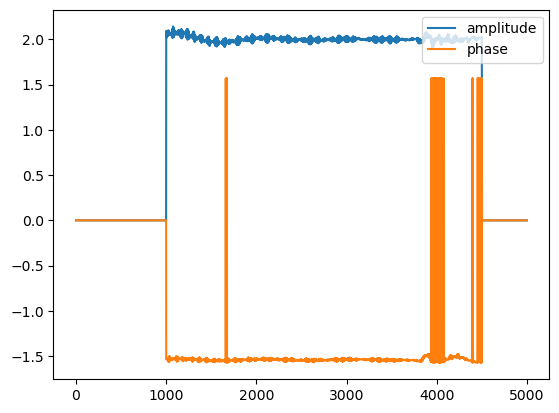

In [2]:
# extraction of amplitude and phases
# consider two reference pulses taken at time timesteps (last and second last)
# upon expansion, these can be modeled into a system of simultaneous equations, subsuming the Amp and Phase dependence into the unknown variables (CHECK EXPLANATION)

import numpy as np

# # Define the matrix A and vector b
A = np.array([[np.sin(omega*4999*dt), np.cos(omega*4999*dt)], [np.sin(omega*4998*dt), np.cos(omega*4998*dt)]])
b = np.array([E_ref_probe[4999], E_ref_probe[4998]])

# # Solve for x
x = np.linalg.solve(A, b)

# extraction 
amplitude = np.sqrt(x[0]**2+x[1]**2)
phase = np.arctan(x[1]/x[0])

amplitude, phase

amplitude = np.zeros(Nt)
phase = np.zeros(Nt)
for i in range (1000, 4500):
    j = i+1
    A = np.array([[np.sin(omega*j*dt), np.cos(omega*j*dt)], [np.sin(omega*i*dt), np.cos(omega*i*dt)]])
    b = np.array([E_ref_probe[j], E_ref_probe[i]])
    
    x = np.linalg.solve(A, b)
    
    amplitude[i] = np.sqrt(x[0]**2+x[1]**2)
    phase[i] = np.arctan(x[1]/x[0])
    
plt.plot(amplitude, label="amplitude")
plt.plot(phase, label="phase")
plt.legend(loc = "upper right")
